In [369]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import extcolors
import skimage
import scipy
from PIL import Image
import math
import skimage
from sklearn.linear_model import LinearRegression
import pandas as pd
from colormap import rgb2hex
import numpy as np
import cv2
import os
from sympy import Point, Line


In [401]:
VID = 0
SING_IMG = 1


def obtain_name_images(image_folder):

    lst = os.listdir(image_folder)
    lst.sort()

    name_images = [img for img in lst 
                if img.endswith(".jpg") or
                    img.endswith(".jpeg") or
                    img.endswith("png")]

    return name_images 

def obtain_images(name_images, image_folder, mode):
    imgs = []

    if mode == VID : 
        for name in name_images:
            img = cv2.imread(os.path.join(image_folder, name))
            if img is not None : 
                img_small = img_resize(img)
                imgs.append(img_small)

    if mode == SING_IMG :
        print('image read : ', os.path.join(image_folder, name_images))
        img = cv2.imread(os.path.join(image_folder, name_images))
        if img is not None : 
            img_small = img_resize(img)
            imgs.append(img_small)
        else : 
            print('no image read')

    if (len(imgs) != 0) : 
        return imgs
    
    return None


def img_resize(img):
    #resize
    output_width = 900  #set the output size
    wpercent = (output_width/float(img.shape[1]))
    hsize = int((float(img.shape[0])*float(wpercent)))
    img = cv2.resize(img, (output_width,hsize), interpolation = cv2.INTER_AREA) #this resize makes the video not work??
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

def donuts(colors_x): 
    colors_pre_list = str(colors_x).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df_color = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])
    list_color = list(df_color['c_code'])
    list_precent = [int(i) for i in list(df_color['occurence'])]
    text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(list_color,
                                                                                list_precent)]
    fig, ax = plt.subplots(figsize=(90,90),dpi=10)
    wedges, text = ax.pie(list_precent,
                        labels= text_c,
                        labeldistance= 1.05,
                        colors = list_color,
                        textprops={'fontsize': 120, 'color':'black'}
                        )
    plt.setp(wedges, width=0.3)

    #create space in the center
    plt.setp(wedges, width=0.36)

    ax.set_aspect("equal")
    fig.set_facecolor('white')
    plt.show()

def colors_to_array(colors_x) : 
    colors_rgb = np.zeros((len(colors_x[0]),3))
    colors_lab = np.zeros((len(colors_x[0]),3))

    for i in range(len(colors_x[0])):
        col = colors_x[0][i][0]
        colors_rgb[i]=col
        colors_lab[i] = skimage.color.rgb2lab((col[0]/255, col[1]/255, col[2]/255))

    return colors_rgb, colors_lab

def mask_vegetation(img_lab, col_lab):
    # Using inRange method, to create a mask
    thr = [8,8,8] #TO DO : maybe change  thr according to histogram ??
    lower_col = col_lab - thr
    upper_col = col_lab + thr
    mask = cv2.inRange(img_lab, lower_col, upper_col)
    return mask


#Detect Sky Region (small variance between px)
#Given the mask, make where the land is black
def cal_skyline(mask):
    h, w = mask.shape
    for i in range(w): #for each column
        raw = mask[:, i]
        after_median = scipy.signal.medfilt(raw, 19)
        try:
            first_zero_index = np.where(after_median == 0)[0][0]
            first_one_index = np.where(after_median == 1)[0][0]
            if first_zero_index > 20: #if the sky is bigger then 20 px starting from the top
                mask[first_one_index:first_zero_index, i] = 1 #put 1 between sky and land
                mask[first_zero_index:, i] = 0 #put 0 in land (appears black)
                mask[:first_one_index, i] = 0 #put 0 before the sky starts 
        except:
            continue
    return mask

def get_sky_region_gradient(img):
    h, w, _ = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.blur(img_gray, (9, 3))
    img_gray= cv2.medianBlur(img_gray, 5)
    lap = cv2.Laplacian(img_gray, cv2.CV_8U)
    gradient_mask = (lap < 6).astype(np.uint8) # we keep region with small laplacian ->sky
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
    mask = cv2.morphologyEx(gradient_mask, cv2.MORPH_ERODE, kernel) #erosion that takes the minimum of neighbouring px
    mask_sky = cal_skyline(mask)
    after_img = cv2.bitwise_and(img, img, mask=mask_sky)
    return after_img

#Cut from the top until less then 60% of sky is detected
def cut_image_from_mask(grad_sky,img):
    low = np.array([1,1,1])
    high = np.array([256,256,256])
    masked_sky = cv2.inRange(grad_sky, low, high)
    h,w = masked_sky.shape
    i = h
    count = flag = j = 0
    img_new = img
    while((i>0) & (flag==0)):
        i=i-1 
        j = count = 0
        while(j<w):
            if (masked_sky[i,j] == 255) : # if px is sky 
                count = count + 1
            j=j+1
            if (count > (w*0.3)): #cut until 30% of the line isn't sky
                lim = i; 
                flag = 1

    img_new = img[lim:,:,:]


    #cv2.imshow('Image with Sky cut out', cv2.cvtColor(img_new, cv2.COLOR_BGR2RGB))
    #cv2.waitKey(2000)
    
    return img_new

def colors_to_array(colors_x) : 
    colors_rgb = np.zeros((len(colors_x[0]),3))
    colors_lab = np.zeros((len(colors_x[0]),3))

    for i in range(len(colors_x[0])):
        col = colors_x[0][i][0]
        colors_rgb[i]=col
        colors_lab[i] = skimage.color.rgb2lab((col[0]/255, col[1]/255, col[2]/255))

    return colors_rgb, colors_lab

def mask_vegetation(img_lab, col_lab):
    # Using inRange method, to create a mask
    thr = [8,8,8] #TO DO : maybe change  thr according to histogram ??
    lower_col = col_lab - thr
    upper_col = col_lab + thr
    mask = cv2.inRange(img_lab, lower_col, upper_col)
    return mask

def hough_line_detector(mask, img) :
    hough_thresh,hough_min_line,hough_max_gap  = [20,100,100]
    #nb pts pour qu'une ligne soit considérée
    #nb pts à la suite ds la même ligne 
    #dist entre 2 pts pour qu'ils soient reliés

    blur = cv2.medianBlur(mask,3)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(10,1))
    blur = cv2.dilate(blur, kernel)

    hough_image = np.matrix.copy(img)
    i = line_sing_col = 0

    # find the Hough lines using the PPHT method
    lines = cv2.HoughLinesP(image=blur, rho=1, theta=np.pi / 180, threshold=hough_thresh, 
                    minLineLength=hough_min_line, maxLineGap=hough_max_gap)
                    
    if lines is not None:
        line_sing_col = np.zeros((len(lines),4))
        #print("len : ", len(lines))
        #print("size line_sing_col", line_sing_col.shape)

        for x in range(0, len(lines)):
            for x1, y1, x2, y2 in lines[x]:
                if (math.atan2(abs(x1-x2),abs(y1-y2)) < (np.pi/2.5)) : 
                    #print(i)
                    line_sing_col[i,:] = lines[x]
                    i=i+1
                    hough_image = cv2.line(hough_image, (x1, y1), (x2, y2), (0, 0, 255), 1)

        line_sing_col = line_sing_col[:i,:]
    #else:
        #print("No lines")
    #cv2.imshow('HI : ', hough_image)
    #cv2.waitKey(1000)

    return i, hough_image, line_sing_col

def keep_best_mask(arr_mask, img_no_sky, colors_lab):
    max_detected = max_detected_new = 0
    hough_img = 0
    all_lines = []
    idx_best = 0

    for idx, mask in enumerate(arr_mask) : 
        max_detected_new, hough_img_new, line_sing_col_new = hough_line_detector(mask, img_no_sky)
        if (max_detected_new > max_detected) : 
            max_detected = max_detected_new
            best_mask = mask
            hough_img = hough_img_new
            line_sing_col = line_sing_col_new
            idx_best = idx
    
    print(max_detected , 'lines detected for index ', idx_best, 'with color ', colors_lab[idx_best]) 

    return best_mask, colors_lab[idx_best], hough_img_new

def hough_line_improved(mask, angle_acc):
  # Rho and Theta ranges

    mask = cv2.medianBlur(mask,3)
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(2,1))
    #mask = cv2.dilate(mask, kernel)

    thetas = np.deg2rad(np.arange(0, 180))
    width, height = mask.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))   # max_dist
    rhos = np.linspace(-diag_len, diag_len, num = diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    accumulator_for_pres = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(mask)  # (row, col) indexes to edges
    #print(y_idxs, x_idxs)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        #print('step ', i, 'of len ', len(x_idxs))
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
            accumulator[rho, t_idx] += 1
            accumulator_for_pres[rho, t_idx] += 1
            if (abs(np.rad2deg(thetas[t_idx])-90)<20): #if horizontale lignes 
                accumulator[:, t_idx] = 0
            
            for angle in angle_acc:
                if (abs(np.rad2deg(thetas[t_idx])-np.rad2deg(angle))<10): #if angle already detected 
                    accumulator[:, t_idx] = 0


    return accumulator, thetas, rhos

def keep_mask_max_acc_lines(best_mask_edge, img_no_sky, crop_nb):

    best_mask_edge_copy = np.copy(best_mask_edge)
    best_mask_evaluate = np.copy(img_no_sky)
    img_no_sky_copy = np.copy(img_no_sky)

    #crop_nb = 3

    th_acc = []
    r_acc = []
    threshold_acc = []
    mask = []

    for i in range(crop_nb):
        mask_single_crop = np.zeros_like(img_no_sky)

        print('step ', (i+1), 'of ', crop_nb)
        acc, thetas, rhos = hough_line_improved(best_mask_edge_copy, th_acc)

        th_max = acc.max()

        r_idx, th_idx = np.where(acc>=th_max)
        r = rhos[r_idx[0]]#in case multiple same max 
        th = thetas[th_idx[0]]

        th_acc.append(th)
        r_acc.append(r)
        threshold_acc.append(th_max)

        a = math.cos(th)
        b = math.sin(th)
        x0 = a * r
        y0 = b * r
        p1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        p2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

        cv2.line(best_mask_edge_copy, p1, p2, (0,0,0), 30)
        cv2.line(best_mask_evaluate, p1, p2, (255,0,0), 3)
        cv2.line(img_no_sky_copy, p1, p2, (255,0,0), 3)
        cv2.line(mask_single_crop, p1, p2, (255,0,0), 50)
        mask.append(mask_single_crop)

    return mask, th_acc, r_acc, threshold_acc, best_mask_evaluate

def VP_detection(th_acc, r_acc, threshold_acc,img_no_sky_copy ): 
    #VP detection 
    #ADD COND THAT INTERSEECTON MUST BE IN A RADIUS TO AVOID OUTLIERS 
    # => or KMEAN with K = 2?

    A = B = C = D = E = 0

    for t,r,w in zip(th_acc, r_acc, threshold_acc):
        a = np.cos(t)
        b = np.sin(t)
        A = A + w*pow(a,2)
        B = B + w*pow(b,2)
        C = C + w*a*b
        D = D + w*a*r
        E = E + w*b*r

    M = np.array([[A,C],[C,B]])
    #print(np.linalg.det(M))
    b = np.array([D,E])
    x0,y0 = np.linalg.solve(M,b).astype(int)

    cv2.circle(img_no_sky_copy, (x0, y0), 10, (255,255,255), 5)
    #cv2.imshow('VP drawned : ', img_no_sky_copy)
    #cv2.waitKey(1000)

    print('VP is : ', x0, y0)

    return x0,y0

def apply_ransac(img_no_sky, masked_images_i, vp_point, vp_on):

    mask_single_crop = np.zeros_like(img_no_sky)
    x,y = np.where(masked_images_i>0)
    data = np.column_stack([x, y])
    if(vp_on>0):
        vp_point = np.asarray(vp_point)
        n = int(data.shape[0])
        vp_data_x = np.full((n,1), vp_point[1])
        vp_data_y = np.full((n,1), vp_point[0])
        data_vp = np.column_stack([vp_data_x, vp_data_y])
        data = np.row_stack([data, data_vp])

    #print('data : ', data.size)
    #if (data.size<10):
        #cv2.waitKey(20000)
    if (1) : #(data.shape>10):
        model, inliers = skimage.measure.ransac(data, skimage.measure.LineModelND, min_samples=2,
                                    residual_threshold=1, max_trials=100)
        temp = np.copy(masked_images_i)
        y0, x0 = model.params[0]#.astype(int)
        t1, t0 = model.params[1]
        m = t1/t0
        #print(m)
        #ADD CONDITION ON M
        x2 = (x0 + 500)
        y2 = (y0 + 500*m)
        x1 = (x0 - 500)
        y1 = (y0 - 500*m)
        p1 = [int(x1),int(y1)]
        p2 = [int(x2),int(y2)]
    else : 
        p1 = [0,0]
        p2 = [0, 1]
        m  = 0
    return p1, p2, m


def remove_double(p1, p2, m, acc_m, masked_image):
    cond_double = 0
    #print('in')
    #print(acc_m)
    if (len(acc_m)>=1):
        for m_others in acc_m:
            if (abs(m-m_others)<0.1): #if angle already detected 
                #print('diff m', m - m_others)

                cv2.line(masked_image, p1, p2, (0,0,0), 15)
                cond_double = 0
                #print('diff : ', m, m_others)
            
            else : #pas une bonne idée : une crop pourrait en remplacer une autre 
                cond_double = 1
    else : 
        cond_double = 1

    return masked_image, cond_double

def remove_horizon(p1, p2, m, masked_image):
    thr = 0.1
    cond_horizon = 0

    if (abs(m)<thr):
        cv2.line(masked_image, p1, p2, (0,0,0), 15)
        #print('horizon detected', m)

    if (abs(m)>=thr):
        cond_horizon = 1

    return masked_image, cond_horizon

    
def seq_line_det(arr_mask_per_row, best_mask_edge, img_no_sky): 
    pts1 = []
    pts2 = []
    acc_m = []
    masked_images = []
    list_mask = []
    img_no_sky_copy2 = np.copy(img_no_sky)


    for i in range(len(arr_mask_per_row)):
        masked_images.append(cv2.bitwise_and(best_mask_edge, arr_mask_per_row[i][:,:,0]))

    for i in range(len(masked_images)):
        #print(i)
        mask_single_crop = np.zeros_like(img_no_sky)
        cond = 0
        #COND ON M AND SPACEMENT BETWEEN ROWS
        m = 0

        cond_horizon = 0
        cond_double = 0
        #p1, p2, m = apply_ransac(img_no_sky, masked_images[i])

    
        while(cond_horizon*cond_double == 0 ): 
            #print('cond : ', cond_horizon, cond_double )
            p1, p2, m = apply_ransac(img_no_sky, masked_images[i])
            #print('m : ', m)
            masked_images[i], cond_horizon = remove_horizon(p1, p2, m, masked_images[i])
            masked_images[i], cond_double = remove_double(p1, p2, m, acc_m, masked_images[i])
            #cond_horizon, cond_double = check_ransac_cond(p1,p2,m, acc_m)

        pts1.append(p1)
        pts2.append(p2)
        acc_m.append(m)
        cv2.line(img_no_sky_copy2, p1, p2, (255,0,0), 3)
        cv2.line(mask_single_crop, p1, p2, (255,0,0), 40)
        list_mask.append(mask_single_crop)
    
    cv2.imshow('ransac', img_no_sky_copy2)

    return list_mask


# 2) DRAW THE RANSAC LINES AND CREATE THE ARRAY OF MASK FOR NEXT PICTURE : 
def draw_ransac_lines(img_no_sky, offset, slope, best_mask_edge):
    img_no_sky_copy2 = np.copy(img_no_sky)
    p1_tot = []
    p2_tot = []
    list_mask = []

    #doesnt appear when slope are negative??
    for i in range(len(offset)):
        mask_single_crop = np.zeros_like(img_no_sky)
        p1 = (int(offset[i]),0)
        p2 = (int(offset[i]+slope[i]*300), 300)
        p1_tot.append(p1)
        p2_tot.append(p2) 
        #print(p1,p2, print('line printed'))

        cv2.line(img_no_sky_copy2, p1, p2, (255,0,0), 3)
        cv2.line(mask_single_crop, p1, p2, (255,0,0), 40)
        list_mask.append(mask_single_crop)

    cv2.imshow('ransac', img_no_sky_copy2)
    #cv2.imshow('results : ', (cv2.bitwise_and(best_mask_edge, list_mask[0]))) #afficher l'image ici?

    #cv2.waitKey(5000)

    #masked_images = []
    #for i in range(len(mask)):
        #masked_images.append(cv2.bitwise_and(best_mask_edge, mask[i][:,:,0]))
    
    return list_mask

image read :  /home/roxane/Desktop/M3_2022/Caterra/dataset_straigt_lines/crop_row_023.JPG


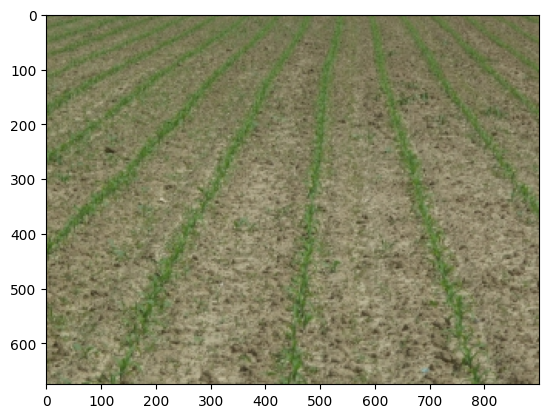

In [371]:
image_folder = '/home/roxane/Desktop/M3_2022/Caterra/dataset_straigt_lines'
name_images = 'crop_row_023.JPG'

sing_image = obtain_images(name_images, image_folder, SING_IMG)[0]
sing_image = cv2.cvtColor(sing_image, cv2.COLOR_BGR2RGB)
plt.imshow(sing_image)

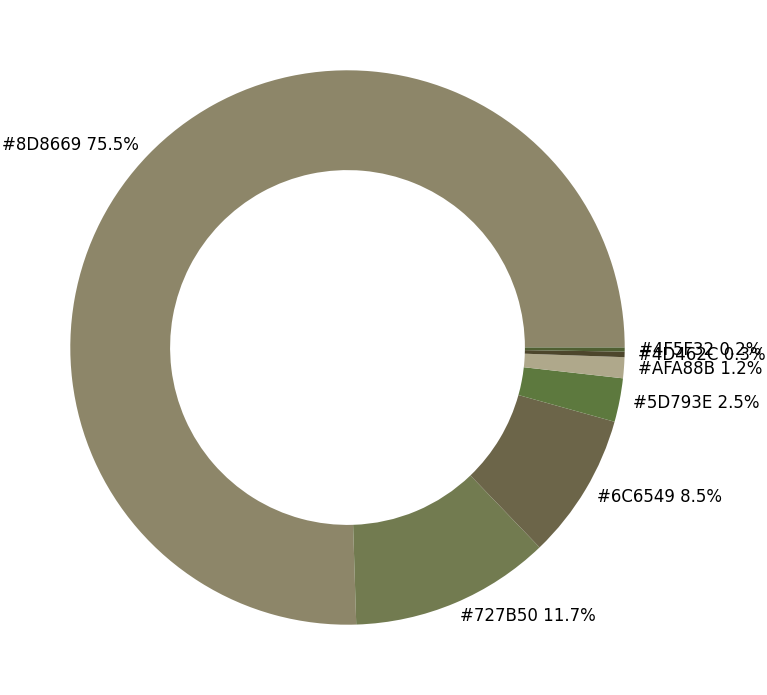

In [372]:
img = sing_image
img_no_sky = sing_image
#extract the main colors from the image 
im_pil = Image.fromarray(img)
colors_x = extcolors.extract_from_image(im_pil, tolerance = 12, limit = 8) 
colors_rgb, colors_lab = colors_to_array(colors_x)
donuts(colors_x)

img_no_sky_lab = skimage.color.rgb2lab(img_no_sky/255)

213.4174313405538
191.88538245525635
174.49641830135081


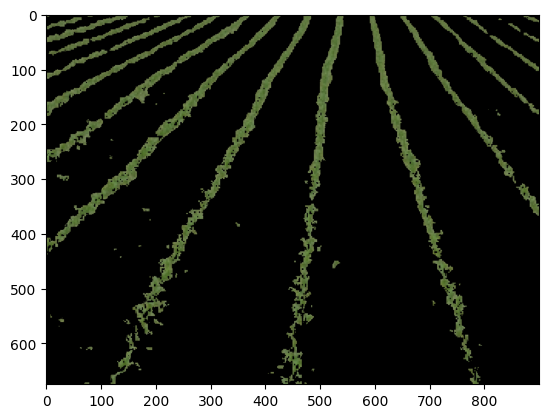

In [373]:
diff_norm = diff_norm_new = float('inf')
for col in colors_rgb:
    diff = np.asarray(col - [0,255,0])
    diff_norm = np.linalg.norm(diff)
    if diff_norm_new>diff_norm:
        diff_norm_new=diff_norm
        col_best_mask = col
        print(diff_norm_new)


col_best_mask_lab = skimage.color.rgb2lab((col_best_mask[0]/255, col_best_mask[1]/255, col_best_mask[2]/255))
best_mask = mask_vegetation(img_no_sky_lab, col_best_mask_lab)
best_mask_edge = cv2.Canny(best_mask,100,200)
plt.imshow(cv2.bitwise_and(sing_image,sing_image, mask = best_mask))

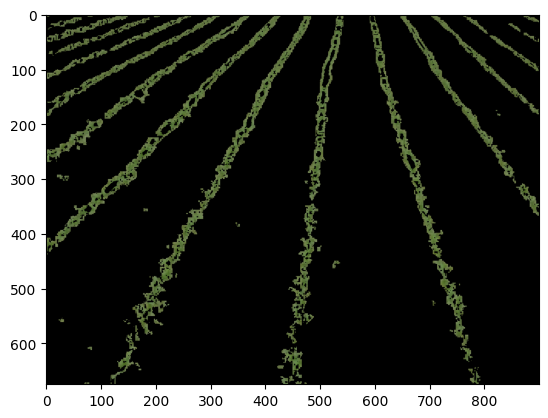

In [374]:
def get_sky_region_gradient(img):
    h, w = img.shape
    img_gray = img #cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.blur(img_gray, (9, 3))
    img_gray= cv2.medianBlur(img_gray, 15)
    lap = cv2.Laplacian(img_gray, cv2.CV_8U)
    gradient_mask = (lap < 1).astype(np.uint8) # we keep region with small laplacian ->sky
    mask = gradient_mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask = cv2.morphologyEx(gradient_mask, cv2.MORPH_ERODE, kernel) #erosion that takes the minimum of neighbouring px
    #mask_sky = cal_skyline(mask)
    #after_img = cv2.bitwise_and(img, img, mask=mask_sky)
    #img_gray = cv2.blur(img_gray, (9, 3))

    return mask #after_img

best_mask_lap = get_sky_region_gradient(best_mask)
temp = cv2.bitwise_and(sing_image,sing_image, mask = best_mask)
image_veg = cv2.bitwise_and(temp,temp, mask = 1- best_mask_lap)
median = image_veg #cv2.medianBlur(image_veg,3)
plt.imshow(image_veg)

(Text(0.5, 1.0, 'only_contours'), ([], []), ([], []))

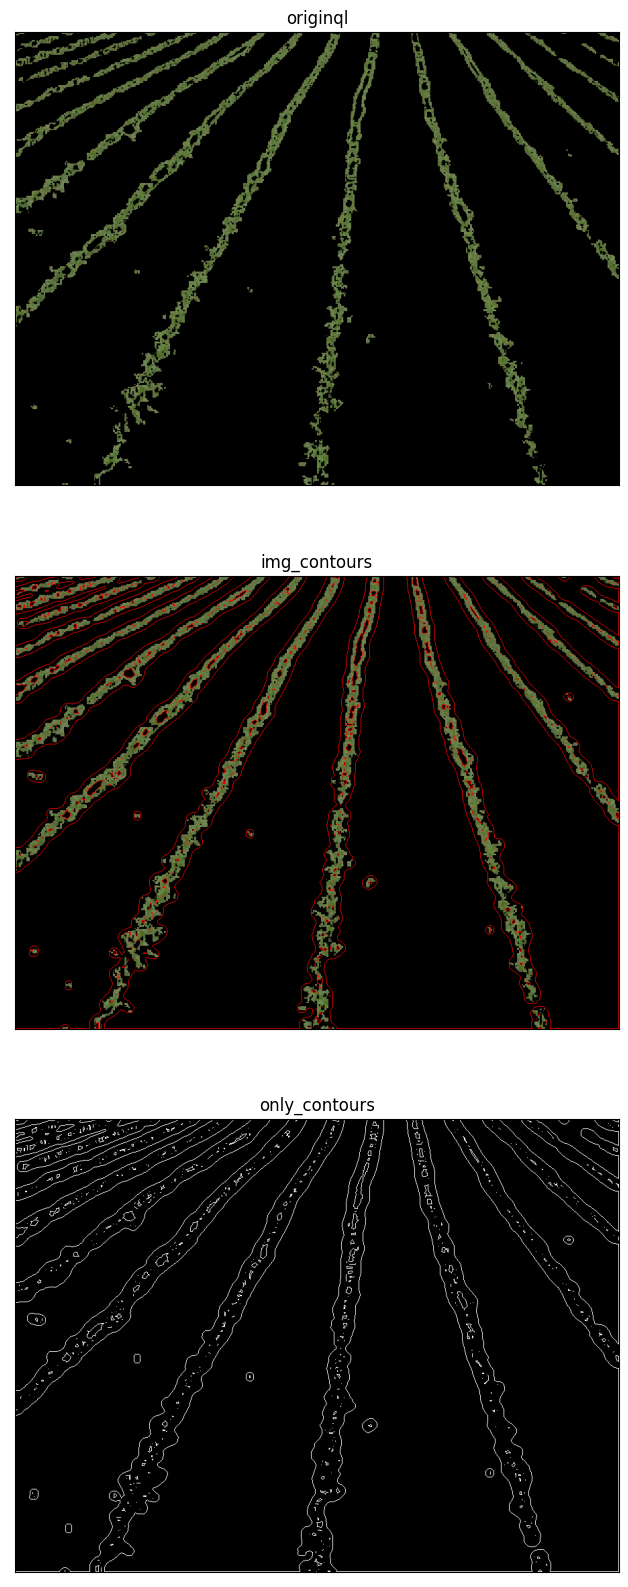

In [375]:
#find and draw countours on image
img_contours = median.copy()
only_contours = np.zeros((median.shape[0],median.shape[1]))

ret, thresh = cv2.threshold(median, 1, 255, 0)
#plt.imshow(thresh)
contours, hierarchy = cv2.findContours(best_mask_lap, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_contours, contours, -1, (250,0,0), 1)
cv2.drawContours(only_contours, contours, -1, (250,0,0), 1)


plt.figure(figsize=(10, 20))
plt.subplot(3,1,1),plt.imshow(median,cmap = 'gray')
plt.title('originql'), plt.xticks([]), plt.yticks([])
plt.subplot(3,1,2),plt.imshow(img_contours,cmap = 'gray')
plt.title('img_contours'), plt.xticks([]), plt.yticks([])
plt.subplot(3,1,3),plt.imshow(only_contours,cmap = 'gray')
plt.title('only_contours'), plt.xticks([]), plt.yticks([])



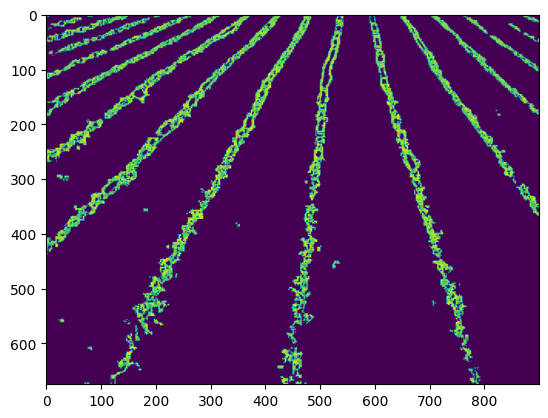

In [376]:
#median.shape
gray_nomedian = cv2.cvtColor(image_veg, cv2.COLOR_BGR2GRAY)
#print(gray.shape)
#plt.imshow(gray)

#before is too long if we dont do it on countours 
edge = cv2.Canny(gray_nomedian,100,200)
plt.imshow(gray_nomedian)

step  1 of  10
step  2 of  10
step  3 of  10
step  4 of  10
step  5 of  10
step  6 of  10
step  7 of  10
step  8 of  10
step  9 of  10
step  10 of  10
VP is :  531 -119


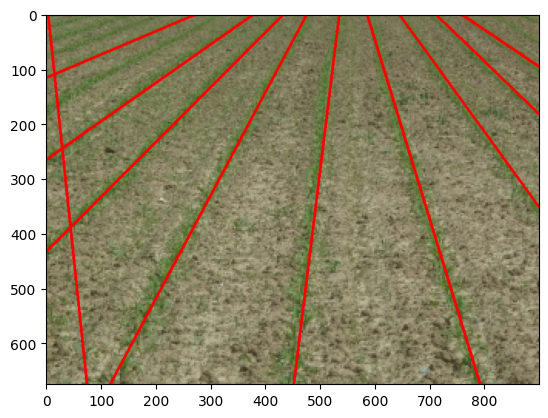

In [428]:
#median.shape
gray = cv2.cvtColor(median, cv2.COLOR_BGR2GRAY)
#print(gray.shape)
#plt.imshow(gray)

#before is too long if we dont do it on countours 
edge = cv2.Canny(gray_nomedian,100,200)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(2,1))
edge = cv2.dilate(edge, kernel)
gray = cv2.cvtColor(image_veg, cv2.COLOR_BGR2GRAY)
gray = cv2.dilate(gray, kernel)

crop_nb = 10

arr_mask, th_acc, r_acc, threshold_acc, best_mask_evaluate = keep_mask_max_acc_lines(edge, img_no_sky, crop_nb)
x0,y0 = VP_detection(th_acc, r_acc, threshold_acc, best_mask_edge)
vp_point = [x0,y0]
img_no_sky_copy = np.copy(img_no_sky)
plt.imshow(best_mask_evaluate)

In [430]:
copy = arr_mask

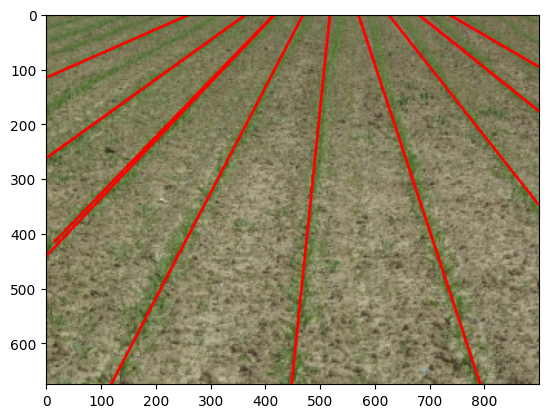

In [410]:
image = img_no_sky
img_lab = skimage.color.rgb2lab(image/255) #calculate best color mask based on previously calculated color 
mask_col = mask_vegetation(img_lab, col_best_mask_lab)

# mask_col_edge = cv2.Canny(mask_col,100,200) #add la cond sur le laplacien 
arr_mask_per_row = arr_mask
best_mask_edge = mask_col
img_no_sky = image

pts1 = []
pts2 = []
acc_m = []
masked_images = []
arr_mask = []
img_no_sky_copy2 = np.copy(img_no_sky)
cr = np.zeros_like(gray)


for i in range(len(arr_mask_per_row)):
    masked_images.append(cv2.bitwise_and(best_mask_edge, arr_mask_per_row[i][:,:,0]))


for i in range(len(masked_images)): #for each row
    mask_single_crop = np.zeros_like(gray)
    cond = m = cond_horizon = cond_double = 0


    while(cond_horizon*cond_double == 0 ): 
        #print('cond : ', cond_horizon, cond_double )
        p1, p2, m = apply_ransac(img_no_sky, masked_images[i], vp_point, 1)
        #print('m : ', m)
        masked_images[i], cond_horizon = remove_horizon(p1, p2, m, masked_images[i])
        masked_images[i], cond_double = remove_double(p1, p2, m, acc_m, masked_images[i])
        #cond_horizon, cond_double = check_ransac_cond(p1,p2,m, acc_m)

    pts1.append(p1)
    pts2.append(p2)
    acc_m.append(m)
    cv2.line(img_no_sky_copy2, p1, p2, (255,0,0), 3)
    cv2.line(cr, p1, p2, (255,0,0), 1)

    cv2.line(mask_single_crop, p1, p2, (255,0,0), 40)
    arr_mask.append(mask_single_crop)

plt.imshow(img_no_sky_copy2)

masked_img = arr_mask

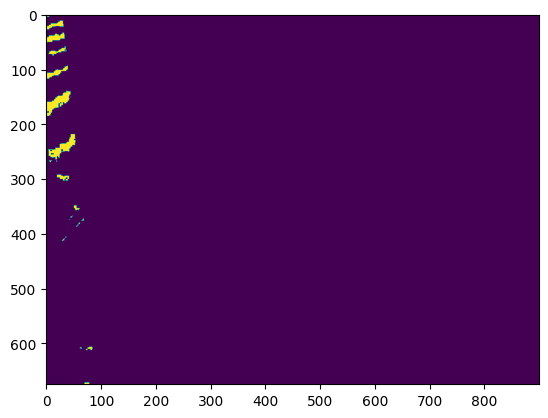

In [426]:
plt.imshow(masked_images[9])


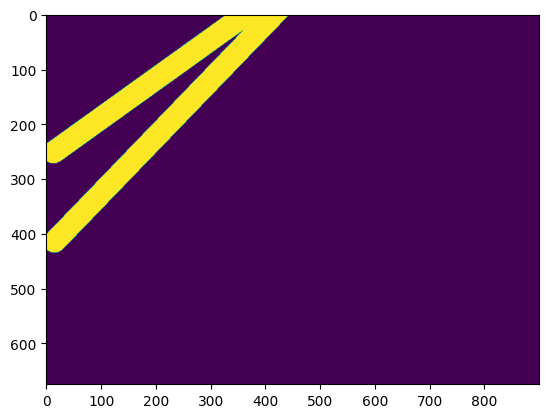

In [427]:
plt.imshow(masked_images[9])
cond_horizon=cond_double=0
while(cond_horizon*cond_double == 0 ): 
    #print('cond : ', cond_horizon, cond_double )
    p1, p2, m = apply_ransac(img_no_sky, masked_images[i], vp_point, 1)
    #print('m : ', m)
    masked_images[i], cond_horizon = remove_horizon(p1, p2, m, masked_images[i])
    masked_images[i], cond_double = remove_double(p1, p2, m, acc_m, masked_images[i])
    #cond_horizon, cond_double = check_ransac_cond(p1,p2,m, acc_m)

pts1.append(p1)
pts2.append(p2)
acc_m.append(m)
cv2.line(img_no_sky_copy2, p1, p2, (255,0,0), 3)
cv2.line(cr, p1, p2, (255,0,0), 1)

cv2.line(mask_single_crop, p1, p2, (255,0,0), 40)
plt.imshow(mask_single_crop)

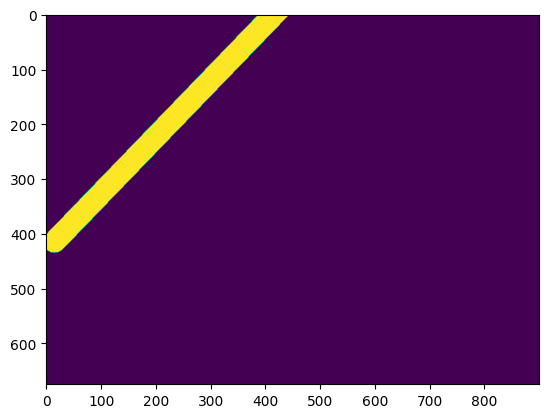

In [422]:
plt.imshow(arr_mask[9])

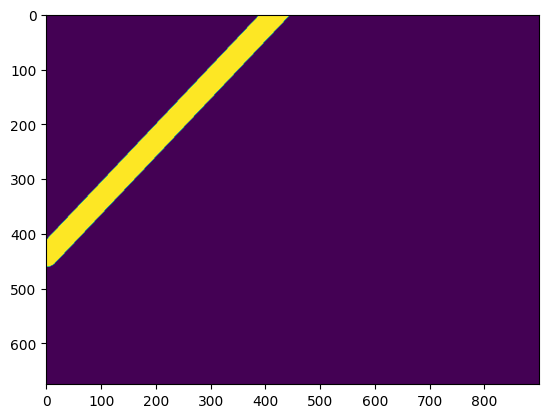

In [421]:
plt.imshow(arr_mask[0])

In [339]:
with open('readme.txt', 'w') as f:
    for nb_line, line in enumerate(cr) : #= cr[0] 
        x = np.where(line>0)
        pt = []
        for x_sing in x[0] : 
            #pt.append((x_sing, nb_line))
            pt.append((x_sing, nb_line))
        pt = str(pt)
        f.write(pt)
        f.write('\n')


In [340]:
def pattern_ransac(arr_mask, vp_point, max_iterations=100, threshold=5):
    best_model = None 
    best_nb_inliers = 0
    nb_cr = len(arr_mask)
    data = np.zeros(((nb_cr+1),2)) #+1 for the VP point 

    list_cr_lines = []

    for it in range(max_iterations):
        list_cr_lines = []

        #print('it : ', it)
        nb_inliers = 0

        rand_vp = [vp_point[0] + np.random.randint(-10,10), vp_point[1] + np.random.randint(-10, 10)]
        #print(vp_point, rand_vp)
        #print(data[nb_cr])

        #first randomly select data 
        data[nb_cr] = rand_vp
        for i in range(nb_cr): #select randomlw one point from each mask
            row = cv2.bitwise_and(best_mask, arr_mask[i])
            x,y = np.where(row>0)
            rand_nb = np.random.randint(0, len(x)-1)
            data[i] = [x[rand_nb], y[rand_nb]]
            pt1 = (rand_vp[0], rand_vp[1])
            pt2 = (x[rand_nb], y[rand_nb])
            list_cr_lines.append([pt1, pt2])
        
        
        #calculate error 
        for i in range(nb_cr):
            row = cv2.bitwise_and(best_mask_edge, arr_mask[i])
            x,y = np.where(row>0)
            print(len(x))
            for x_x, y_y in zip(x,y):
                #print(list_cr_lines[i][1])
                p1 = np.array(pt1)
                p2 = np.array(pt2)
                p3 = np.array(x_x,y_y)

                err = np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
                #calculate_err(list_cr_lines[i][0],list_cr_lines[i][1], (x_x, y_y))
                #err = list_cr_lines[i].distance(Point(x_x, y_y))
                #print('err :', err)
                if err<threshold:
                    nb_inliers = nb_inliers + 1
        
        

        model = list_cr_lines
        best_model = model

        if nb_inliers>best_nb_inliers:
            best_nb_inliers = nb_inliers
            print(best_nb_inliers)
            best_model = model
    
    return best_model

In [178]:
def get_slopes_from_points(data):

    slopes = []

    for i in range(len(data)-1):
        d_ver = float(data[i,0]) - float(data[-1,0])
        d_hor = float(data[i,1]) - float(data[-1,1])
        s = d_hor/d_ver
        slopes.append(s)

    return slopes #return the slope : +1 in verticale, + slope in horizontal 

In [363]:
def squared_distance_to_line(point, line_point1, line_point2):
    # Convert the points to numpy arrays for easier calculations
    point = np.array(point)
    line_point1 = np.array(line_point1)
    line_point2 = np.array(line_point2)

    # Calculate the direction vector of the line
    line_dir = line_point2 - line_point1

    # Calculate the normal vector of the line
    line_normal = np.array([line_dir[1], -line_dir[0]])

    # Calculate the squared distance from the point to the line by taking the dot product of the normal vector
    # with the vector pointing from the line to the point, and then dividing by the square of the length of the normal vector
    return np.dot(line_normal, point - line_point1)**2 / np.dot(line_normal, line_normal)


In [367]:
best_model = None 
nb_cr = len(arr_mask)
data = np.zeros(((nb_cr+1),2)) #+1 for the VP point 
list_cr_lines = []
max_iterations = 100
threshold = 1
list_cr_lines = []
#print('it : ', it)
best_nb_inliers = 0
copy = np.copy(img_no_sky)


for it in range(max_iterations):
    if (it%10==0):
        print(it)
    #print(it)
    list_cr_lines = []
    rand_vp = [vp_point[0] + np.random.randint(-10,10), vp_point[1] + np.random.randint(-10, 10)]

    #first randomly select data 
    data[nb_cr] = rand_vp

    for i in range(nb_cr): #select randomlw one point from each mask
        row = cv2.bitwise_and(best_mask, arr_mask[i])
        y,x = np.where(row>0)
        rand_nb = np.random.randint(0, len(x)-1)
        data[i] = [x[rand_nb], y[rand_nb]]
        pt1 = (rand_vp[0], rand_vp[1])
        pt2 = (x[rand_nb], y[rand_nb])
        list_cr_lines.append([pt1, pt2])

    max_err = 0
    nb_inliers = 0

    #calculate error 
    for i in range(nb_cr):
    #if(1):
        #i=1
        row = cv2.bitwise_and(best_mask_edge, arr_mask[i])
        y,x = np.where(row>0)
        [p1,p2] = np.array(list_cr_lines[i])
        #print([p1,p2])
        for x_x, y_y in zip(x,y):
            p3 = np.array([x_x,y_y])
            #err = np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
            err = squared_distance_to_line(p3, p1, p2)
            if (abs(err)<threshold):
                #print('err : ', abs(err))
                nb_inliers = nb_inliers + 1
  
    if nb_inliers>best_nb_inliers:
        #print('best : ', nb_inliers, best_line_single_cr)
        best_model = list_cr_lines
        best_nb_inliers = nb_inliers

0
10
20
30
40
50
60
70
80
90


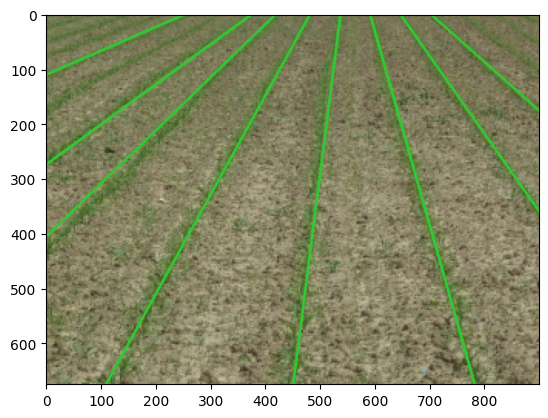

In [368]:
copy = np.copy(img_no_sky)

for crop in best_model:
    crop = np.asarray(crop)
    diff = (crop[1]-crop[0])
    cv2.line(copy, crop[0], crop[1]+5*diff, (50,200,50), 3)

plt.imshow(copy)

In [ ]:
th_acc_copy = th_acc

th_acc_copy.sort()
d_th_acc = []
for i in range(len(th_acc)-1):
    d_th = th_acc_copy[i+1]-th_acc_copy[i]
    d_th_acc.append(d_th)
    print(d_th)

print(d_th_acc)

for i, d in enumerate(d_th_acc):
    print(i,d)

d_th_med = np.median(d_th_acc)
d_th_acc_new = d_th_acc
for i, d_th in enumerate(d_th_acc):
    print(i, d_th_acc)
    if (d_th>1.75*d_th_med):
        new = (th_acc_copy[i]+th_acc_copy[i])/2
        d_th_acc_new = d_th_acc_new.append(new)

#av_d = np.median(th_acc)
print(av_d)
th_acc.sort()

for i in range(len(th_acc)-1):
    print(th_acc[i+1]-th_acc[i])
    #print(th_acc[i+1]-th_acc[i])
for t in th_acc:
    av_d = np.median(th_acc)
    print(t)
    if t-t_old>1.5*